## Concept of Transformer

### What is Transformer?

The Transformer is a deep learning architecture that was introduced in the paper ["Attention is All You Need"](https://arxiv.org/pdf/1706.03762) by Vaswani et al. in 2017. It is primarily used in natural language processing (NLP) tasks like translation, text generation, and language modeling, but its applications have expanded to other fields like computer vision and speech processing. The key innovation in the Transformer is its use of **self-attention** to capture relationships in data without relying on sequential processing, which is typical in models like RNNs and LSTMs.

List of modern models (and their domains) that are based on Transformer architecture:

* **NLP**: BERT, GPT, LLaMa, Gemini, Claude, ...
* **Vision**: ViT, DETR
* **Multimodal (Text + Image)**: CLIP, DALL-E
* **Speech**: Whisper

### Transformer Advantages

1. **Parallelization**

    Unlike RNNs, which process tokens one by one, the Transformer processes all tokens at once, making it highly efficient, especially for long sequences.

2. **Long-Range Dependencies**

    The self-attention mechanism enables the model to capture dependencies between distant words in a sequence.

3. **Scalability**

    Transformers are scalable and can handle very large datasets, making them ideal for models like GPT-3 or BERT.

### Transformer Architecture

Vanilla Transformer architecture implements Encoder-Decoder architecture. **Encoder** processes the input sequence and generates a vector representations of the input texts. **Decoder** uses the encoded information and produces the output sequence. However, some models use just the encoder (e.g., BERT) or just the decoder (e.g., GPT), depending on the task.

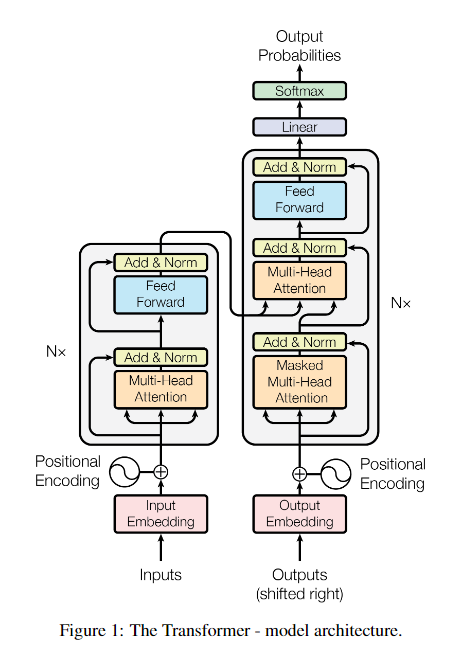

#### Encoder

The encoder usually consists of several (often 6 or 12) so-called "Transformer Encoder Layers" and all of them are identical. Each encoder layer includes two sub-layers: **Multi-Head Self-Attention Mechanism** and **Position-wise Feedforward Network**

**Multi-Head Self-Attention Mechanism**



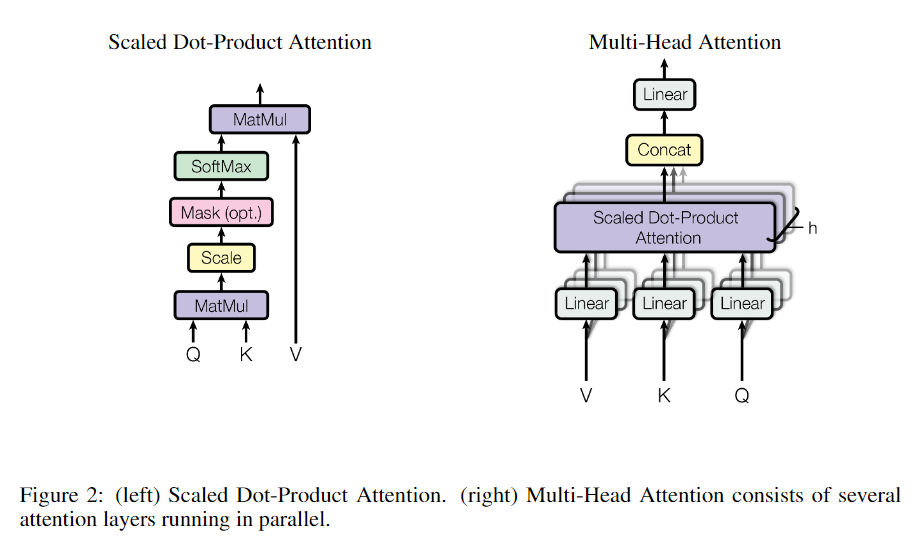

Self-attention is the mechanism that allows the Transformer to focus on different parts of the input sequence when processing a word. It calculates how much focus each word should have on the others. This allows the model to capture dependencies between words, regardless of their distance from each other.

For each word (or token), the model computes three vectors: Query $Q$, Key $K$, Value $V$. These vectors are computed by multiplying the word’s embedding by learned weight matrices. Then, attention scores are calculated by computing the dot product of the Query and Key vectors:

$$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

where $Q$ - query matrix, $K$ - key matrix, $V$ - value matrix, $d_k$ - dimensionality of the keys.



The resulting attention scores determine how much focus to place on each word in the sequence.

Instead of calculating attention once, the model uses **multiple attention "heads"** to capture different types of relationships between words. Each head processes attention in parallel but with different learned weights:

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \dots, \text{head}_h)W^O $$

$$\text{where} \  \text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

where $W_i^Q$, $W_i^K$, $W_i^V$ are learnable parameter matrices.

After concatenating the heads, a linear transformation is applied to produce the final output.

**Position-wise Feedforward Network**

After the multi-head attention, each token passes through a feedforward network, which consists of two linear transformations with a ReLU activation in between:

$$ \text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2 $$




This network is applied independently to each position in the sequence.

#### Decoder

The decoder has a structure similar to the encoder but with one key difference—it includes an additional **masked self-attention layer** to ensure that each position can only attend to previous positions. This prevents the model from "cheating" by looking at future words during training.

Each decoder layer contains:

* **Masked Multi-Head Self-Attention**: Ensures that the model only attends to earlier positions when predicting the next word.
* **Multi-Head Attention**: Attends to the output of the encoder.
* **Position-Wise Feedforward Network**: Similar to the encoder.

#### Positional Encodings

Transformers do not have a built-in notion of the order of words (unlike RNNs). To incorporate the sequence order, positional encodings are added to the input embeddings. These are vectors that provide information about the position of a token in the sequence.

Common positional encodings are based on sine and cosine functions of different frequencies:



$$ PE_{(\text{pos}, 2i)} = \sin\left(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}\right) $$


$$ PE_{(\text{pos}, 2i+1)} = \cos\left(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}\right) $$

Where $\text{pos}$ is the position of the word in the sequence, $i$ is the dimension index.

#### Residual Connections and Layer Normalization

Each sub-layer (both in the encoder and decoder) is followed by a residual connection and layer normalization, which helps with training stability and faster convergence:

$$ \text{LayerNorm}(x + \text{Sublayer}(x)) $$



### Traning Objective

For tasks like translation, the Transformer is trained to minimize the difference between the predicted and true output sequences, often using **cross-entropy loss**.

### READING
["Attention is All You Need"](https://arxiv.org/pdf/1706.03762)

["Introduction to trasformers"](https://arxiv.org/pdf/2304.10557)

["Implementation transformers"](https://www.kaggle.com/code/andreizhdanov/transformer/edit)

## Example of implementition on Machine Translation

Vanilla Transformer can be used to implement a translator from one language to another. This task is called Machine Translation (MT). Here we will implement Vanilla Transformer using PyTorch to translate English text to French.

First, let us install necessary packages and import necessary libraries

In [1]:
!pip install -U transformers huggingface_hub
!pip install -U datasets
!pip install -U sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 104.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavio

In [2]:
import torch
from torch import nn
import torch.optim as optim
import math

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Positional Encoding

Now, let's implement calculation of the positional encoding

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        # Initialize the PositionalEncoding class
        super(PositionalEncoding, self).__init__()

        # Create a tensor to store positional encodings with shape (max_len, d_model)
        # max_len: maximum length of the input sequence
        # d_model: dimension of the model embeddings (matches token embedding size)
        self.encoding = torch.zeros(max_len, d_model)

        # Create a tensor of positions from 0 to max_len-1 with shape (max_len, 1)
        # Each row represents the position of a word in the sequence
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Compute the denominator for the sine and cosine positional encodings
        # This creates a scaling factor based on the position in the model dimension (d_model)
        # d_model is divided by 2 since we alternate between sine and cosine encodings
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even dimensions (0, 2, 4, ...) of the positional encoding
        # This is done by multiplying the position by the div_term and applying sin
        self.encoding[:, 0::2] = torch.sin(position * div_term)

        # Apply cosine to odd dimensions (1, 3, 5, ...) of the positional encoding
        # This is done by multiplying the position by the div_term and applying cos
        self.encoding[:, 1::2] = torch.cos(position * div_term)

        # Add an extra dimension at the start to match the batch size during training
        # Shape becomes (1, max_len, d_model), allowing it to be added to input sequences
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        # Add the positional encoding to the input tensor (x), ensuring that it is on the same device (CPU or GPU)
        # The encoding tensor is sliced to match the sequence length of the input (x.size(1))
        # This step adds positional information to the input embeddings
        x = x + self.encoding[:, :x.size(1), :].to(x.device)
        return x


## Transformer

Here we implement the Transformer architecture in `nn.Module`. PyTorch provides ready-to-use implementations of [Transformer Encoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html) and [Transformer Decoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html).

Before using Encoder and Decoder you need to create [Transformer Encoder Layer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html) and [Transformer Decoder Layer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html). These layers should be passed to Encoder and Decoder.

In [5]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        src_vocab_size,        # Vocabulary size of the source language (input)
        tgt_vocab_size,        # Vocabulary size of the target language (output)
        d_model=512,           # Dimension of model embeddings (default 512)
        nhead=8,               # Number of attention heads in multi-head attention (default 8)
        num_encoder_layers=6,  # Number of layers in the Transformer encoder (default 6)
        num_decoder_layers=6,  # Number of layers in the Transformer decoder (default 6)
        dim_feedforward=2048,  # Dimension of the feedforward network inside the Transformer (default 2048)
        dropout=0.1            # Dropout rate (default 0.1)
    ):
        # Initialize the nn.Module parent class
        super(TransformerModel, self).__init__()

        # Source embedding layer that converts input tokens to embeddings of size d_model
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)

        # Target embedding layer that converts target tokens to embeddings of size d_model
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # Positional encoding for the embeddings to encode the positions of tokens in the sequence
        self.positional_encoding = PositionalEncoding(d_model)

        # Create a single layer of Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model,            # Size of each embedding (input dimension)
            nhead,              # Number of heads in multi-head attention
            dim_feedforward,    # Dimension of the feedforward network
            dropout,            # Dropout rate for regularization
            batch_first=True    # Ensures that the batch dimension comes first
        )

        # Stack multiple encoder layers (num_encoder_layers defines how many)
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_encoder_layers
        )

        # Create a single layer of Transformer decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model,            # Size of each embedding (input dimension)
            nhead,              # Number of heads in multi-head attention
            dim_feedforward,    # Dimension of the feedforward network
            dropout,            # Dropout rate for regularization
            batch_first=True    # Ensures that the batch dimension comes first
        )

        # Stack multiple decoder layers (num_decoder_layers defines how many)
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_decoder_layers
        )

        # Final linear layer to map the decoder output to the target vocabulary size
        # The output dimension is the size of the target vocabulary (tgt_vocab_size)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

        # Store the model embedding dimension (d_model) for scaling later
        self.d_model = d_model

    def forward(
        self,
        src,                    # Source sequence (input)
        tgt,                    # Target sequence (input for the decoder)
        src_mask,               # Mask for the source sequence (to avoid attending to padding tokens)
        tgt_mask,               # Mask for the target sequence (prevents attention to future tokens)
        src_padding_mask,       # Padding mask for the source (to avoid attention to padding)
        tgt_padding_mask,       # Padding mask for the target (to avoid attention to padding)
        memory_key_padding_mask # Padding mask for the memory (encoder output) in the decoder
    ):
        # Embed the source sequence and scale by sqrt of d_model for stable gradients
        src_emb = self.src_embedding(src) * math.sqrt(self.d_model)

        # Embed the target sequence and scale by sqrt of d_model
        tgt_emb = self.tgt_embedding(tgt) * math.sqrt(self.d_model)

        # Add positional encodings to the source embeddings
        src_emb = self.positional_encoding(src_emb)

        # Add positional encodings to the target embeddings
        tgt_emb = self.positional_encoding(tgt_emb)

        # Pass the source embeddings through the Transformer encoder
        # The encoder produces a memory representation for the source sequence
        memory = self.transformer_encoder(
            src_emb,                       # Source embeddings with positional encoding
            mask=src_mask,                 # Optional source mask for attention
            src_key_padding_mask=src_padding_mask # Padding mask for the source
        )

        # Pass the target embeddings and the memory (encoder output) through the Transformer decoder
        # The decoder attends to both the target sequence and the encoder's memory
        output = self.transformer_decoder(
            tgt_emb,                       # Target embeddings with positional encoding
            memory,                        # Encoder output (memory)
            tgt_mask=tgt_mask,             # Mask for the target sequence (prevents attending future tokens)
            memory_mask=src_mask,          # Mask applied to memory from the encoder
            tgt_key_padding_mask=tgt_padding_mask, # Padding mask for the target
            memory_key_padding_mask=memory_key_padding_mask # Padding mask for memory (encoder output)
        )

        # Apply the final linear layer to map the decoder output to the target vocabulary
        output = self.fc_out(output)

        # Return the final output (logits over the target vocabulary)
        return output


## Mask Generation Functions

It is also necessary to implement functions that create masks for the input data

In [6]:
def generate_square_subsequent_mask(sz):
    # Create a square matrix of size (sz, sz) filled with ones above and on the diagonal, zeros below the diagonal.
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)

    # Convert the mask to a float tensor and fill the zeros with -inf (indicating they should be ignored in attention)
    # and ones with 0.0 (indicating those positions can be attended to).
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

    # Return the final mask
    return mask


In [7]:
def create_padding_mask(seq, pad_idx):
    # Return a boolean mask where the elements in the sequence that are equal to the pad_idx (padding index) are True,
    # indicating that those positions are padding tokens.
    return (seq == pad_idx).float()


## Machine Translation

After we have defined the model, now we can train the model to translate the text from English to French.

So, let's start with loading the dataset

In [8]:
from datasets import load_dataset

texts = load_dataset("opus_books", "en-fr", split='train')

README.md: 0.00B [00:00, ?B/s]

en-fr/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

Here is just some unwrapping of the data. Nothing that important.

In [9]:
src_lang = 'en'
tgt_lang = 'fr'

texts = texts.map(
    lambda x: {
        'en': x['translation']['en'],
        'fr': x['translation']['fr']
    }
)

Map:   0%|          | 0/127085 [00:00<?, ? examples/s]

Definition of how many data samples should be used for training and testing

In [10]:
# Total number of samples
max_size = len(texts)
# max_size = 10000

# Percentage of samples from the total number that will be used for training
train_frac = 0.8 # Percen

# Calculation of exact number of training and testing samples
train_size = int(train_frac * max_size)
test_size = max_size - train_size

# Selection of the data for training and testing according to the number
# of training and testing samples
train_texts = texts.select(range(train_size))
test_texts = texts.select(range(train_size, train_size+test_size))

Wrap the dataset into PyTorch dataset in order to load data with DataLoader

In [11]:
class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, data, src_lang='en', tgt_lang='fr'):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "src": self.data[idx][src_lang],
            "tgt": self.data[idx][tgt_lang]
        }

train_dataset = TranslationDataset(train_texts)
test_dataset = TranslationDataset(test_texts)

For the sake of simplicity, we will use the ready-to-use tokenizer of English and French texts

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")

# Add Begining of Sentence (BOS) token since it is absent in the tokenizer
tokenizer.add_special_tokens({'bos_token': '<BOS>'})

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


1

Create training and testing DataLoaders. Implement `collate_fn` in which we tokenize the batch of text using [`tokenizer.batch_encode_plus`](https://huggingface.co/docs/transformers/v4.45.2/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.batch_encode_plus)

In [13]:
from torch.utils.data import DataLoader

# Define the maximum sequence length and batch size
max_length = 64
batch_size = 64

# Custom function to process and batch data
def collate_fn(batch):
    # Prepend "<BOS>" token to each source text in the batch and tokenize it
    tokenized_src_texts = tokenizer.batch_encode_plus(
        ["<BOS> " + item['src'] for item in batch],  # Add "<BOS>" to the source text before tokenization
        padding="max_length",                        # Pad sequences to the max_length
        max_length=max_length,                       # Define the maximum length for padding/truncation
        truncation=True,                             # Truncate sequences longer than max_length
        return_tensors="pt"                          # Return a PyTorch tensor
    )['input_ids']                                   # Extract the 'input_ids' (token IDs)

    # Prepend "<BOS>" token to each target text in the batch and tokenize it
    tokenized_tgt_texts = tokenizer.batch_encode_plus(
        ["<BOS> " + item['tgt'] for item in batch],  # Add "<BOS>" to the target text before tokenization
        padding="max_length",                        # Pad sequences to the max_length
        max_length=max_length,                       # Define the maximum length for padding/truncation
        truncation=True,                             # Truncate sequences longer than max_length
        return_tensors="pt"                          # Return a PyTorch tensor
    )['input_ids']                                   # Extract the 'input_ids' (token IDs)

    # Return the tokenized and padded source and target texts as tensors
    return {
        'src': tokenized_src_texts,                  # Tokenized source sequences tensor
        'tgt': tokenized_tgt_texts                   # Tokenized target sequences tensor
    }

# Create DataLoader for training data
train_dataloader = DataLoader(
    train_dataset,                                   # Training dataset
    batch_size=batch_size,                           # Batch size for training
    collate_fn=collate_fn,                           # Custom collate function for tokenizing and batching
    shuffle=True                                     # Shuffle the data each epoch
)

# Create DataLoader for test data
test_dataloader = DataLoader(
    test_dataset,                                    # Test dataset
    batch_size=batch_size,                           # Batch size for testing
    collate_fn=collate_fn,                           # Custom collate function for tokenizing and batching
    shuffle=False                                    # Do not shuffle the test data
)


Create an instance of the model, optimizer, and loss

In [14]:
# Retrieve special token indices from the tokenizer
pad_idx = tokenizer.pad_token_id  # Padding token index
bos_idx = tokenizer.bos_token_id  # Beginning of sequence token index
eos_idx = tokenizer.eos_token_id  # End of sequence token index

# Define vocabulary size, adding 1 due to the new BOS token
vocab_size = tokenizer.vocab_size + 1

# Initialize the Transformer model
model = TransformerModel(
    vocab_size,               # Source vocabulary size (input)
    vocab_size,               # Target vocabulary size (output)
    d_model=512,              # Dimensionality of the model (embedding size)
    nhead=8,                  # Number of attention heads in the multi-head attention mechanism
    num_encoder_layers=6,     # Number of layers in the encoder
    num_decoder_layers=6,     # Number of layers in the decoder
    dim_feedforward=2048,     # Dimension of the feedforward network inside each Transformer layer
    dropout=0.1               # Dropout rate for regularization
).to(device)                  # Move the model to the specified device (e.g., GPU or CPU)

# Initialize the optimizer (Adam optimizer with a learning rate of 0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the loss function (Cross-Entropy Loss) with the padding token ignored
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)


Check how many parameters our model has

In [15]:
sum(p.numel() for p in model.parameters())

135613051

Define the function for training the model

In [16]:
from tqdm import tqdm  # Import tqdm for progress bars

def train_model(
    model,                # The Transformer model
    train_loader,         # DataLoader for the training data
    optimizer,            # Optimizer (Adam in this case)
    criterion,            # Loss function (Cross-Entropy Loss)
    pad_idx,              # Padding token index to ignore in loss calculation
    device,               # Device (CPU or GPU)
    num_epochs=10         # Number of epochs to train the model
):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):  # Loop through each epoch
        total_loss = 0  # Initialize total loss for the current epoch

        pbar = tqdm(train_loader)  # Wrap train_loader with tqdm for progress display
        for i, batch in enumerate(pbar):  # Loop through each batch in the training data
            # Move the source and target sequences to the device (e.g., GPU)
            src, tgt = batch['src'].to(device), batch['tgt'].to(device)

            # Prepare input and output sequences for teacher forcing
            tgt_input = tgt[:, :-1]  # Target input (remove the last token)
            tgt_output = tgt[:, 1:]  # Target output (shifted by one token)

            # Generate masks for attention
            src_mask = None  # No source mask in this case
            tgt_mask = generate_square_subsequent_mask(  # Generate mask for target input to prevent attending to future tokens
                tgt_input.size(1)
            ).to(device)

            # Create padding masks for both source and target sequences
            src_padding_mask = create_padding_mask(src, pad_idx).to(device)
            tgt_padding_mask = create_padding_mask(tgt_input, pad_idx).to(device)
            memory_padding_mask = create_padding_mask(src, pad_idx).to(device)

            optimizer.zero_grad()  # Zero gradients before backpropagation

            # Forward pass through the model
            output = model(
                src, tgt_input, src_mask, tgt_mask,  # Source and target with their masks
                src_padding_mask, tgt_padding_mask, memory_padding_mask  # Padding masks for the attention mechanism
            )
            output = output.view(-1, output.size(-1))  # Reshape the model's output for calculating loss
            tgt_output = tgt_output.contiguous().view(-1)  # Flatten the target output for loss calculation

            # Compute the loss
            loss = criterion(output, tgt_output)  # Cross-entropy loss
            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update the model's parameters

            total_loss += loss.item()  # Accumulate total loss for this epoch

            # Update the progress bar description with the current average loss
            pbar.set_description(f"Loss: {total_loss / (i + 1)}")


# Call the training function with one epoch of training
train_model(
    model,                 # The Transformer model
    train_dataloader,      # DataLoader for training data
    optimizer,             # Adam optimizer
    criterion,             # Cross-Entropy Loss
    pad_idx,               # Padding index to ignore in the loss
    device,                # Device (GPU or CPU)
    num_epochs=1           # Number of epochs to train
)


Loss: 4.3540292669948055: 100%|██████████| 1589/1589 [11:11<00:00,  2.37it/s]


Check how the model translates the English text

In [17]:
def translate_sentence(model, tokenizer, sentence, max_length, pad_idx, device):
    # Tokenize the input sentence
    model.eval()  # Set the model to evaluation mode
    tokens = tokenizer.encode(sentence, return_tensors="pt").to(device)

    # Ensure tokens are not longer than max_length
    tokens = tokens[:, :max_length]

    # Prepare the input tensor (add batch dimension if necessary)
    src = tokens

    # Initialize the decoder input with <BOS> token
    tgt = torch.tensor([[bos_idx]], dtype=torch.long).to(device)

    # Create padding masks
    src_padding_mask = create_padding_mask(src, pad_idx).to(device)

    # Generate a translation by decoding one token at a time
    for _ in range(max_length):

        with torch.no_grad():
            output = model(
                src, tgt, src_mask=None, tgt_mask=None,
                src_padding_mask=src_padding_mask, tgt_padding_mask=None,
                memory_key_padding_mask=src_padding_mask
            )

        # Get the last predicted token (greedy decoding)
        next_token = output[:, -1, :].argmax(dim=-1).unsqueeze(0)

        # Concatenate predicted token to target sequence
        tgt = torch.cat([tgt, next_token], dim=1)

        # Stop if <EOS> token is predicted
        if next_token.item() == eos_idx:
            break

    # Decode the target tokens back into text
    translated_tokens = tgt.squeeze().tolist()

    # Convert token IDs back to the target language sentence
    translated_sentence = tokenizer.decode(translated_tokens, skip_special_tokens=True)

    return translated_sentence


# Test translation example
for example_idx in range(5):

    example_sentence = test_texts[example_idx]['en']
    refence_sentence = test_texts[example_idx]['fr']
    translated_sentence = translate_sentence(
        model, tokenizer, example_sentence, max_length=max_length, pad_idx=pad_idx, device=device
    )

    print(f"Source sentence: {example_sentence}")
    print(f"Translated sentence: {translated_sentence}")
    print(f"Reference sentence: {refence_sentence}")
    print()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Source sentence: Then we will return with any who may wish to follow us to colonize it definitely, and endow the American Republic with a useful station in this part of the Pacific Ocean!"
Translated sentence: Il y avait été été été été voir un homme, et quelque chose à
Reference sentence: Puis, nous y reviendrons avec tous ceux qui voudront nous suivre pour la coloniser définitivement et doter la république américaine d'une station utile dans cette partie de l'océan Pacifique!

Source sentence: "Hurrah!" exclaimed Pencroft, "and that will be no small present which we shall make to our country!
Translated sentence: -- Mais, dit-il, nous n'est pas qu'est pas qu'
Reference sentence: -- Hurrah! s'écria Pencroff, et ce ne sera pas un petit cadeau que nous ferons là à notre pays!

Source sentence: The colonization is already almost finished; names are given to every part of the island; there is a natural port, fresh water, roads, a telegraph, a dockyard, and manufactories; and there will be

Calculate the metrics of translation quality: [BLEU](https://en.wikipedia.org/wiki/BLEU) score

In [18]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import sacrebleu

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, criterion, pad_idx, device):
    model.eval()
    total_loss = 0
    all_references = []
    all_hypotheses = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            src, tgt = batch['src'].to(device), batch['tgt'].to(device)

            # Prepare input and output sequences
            tgt_input = tgt[:, :-1]  # Input to the decoder
            tgt_output = tgt[:, 1:]  # Target to compare with output

            src_mask = None
            tgt_mask = None

            src_padding_mask = create_padding_mask(src, pad_idx).to(device)
            tgt_padding_mask = create_padding_mask(tgt_input, pad_idx).to(device)
            memory_padding_mask = create_padding_mask(src, pad_idx).to(device)

            # Forward pass
            output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_padding_mask)

            # Compute the loss
            output_flat = output.view(-1, output.size(-1))
            tgt_output_flat = tgt_output.contiguous().view(-1)
            loss = criterion(output_flat, tgt_output_flat)
            total_loss += loss.item()

            # Generate predictions (greedy decoding)
            decoded_sentences = torch.argmax(output, dim=-1)

            # Convert decoded sentences to strings and store for BLEU score calculation
            for i in range(decoded_sentences.size(0)):
                # Remove padding tokens, BOS, and EOS tokens from the predictions
                pred_tokens = decoded_sentences[i].tolist()
                pred_tokens = [token for token in pred_tokens if token != pad_idx]

                # Convert tokens back to string
                hypothesis = tokenizer.decode(pred_tokens, skip_special_tokens=True)

                # Store the generated sentence (hypothesis)
                all_hypotheses.append(hypothesis)

                # Convert target tokens to string
                target_tokens = tgt[i, 1:].tolist()  # Remove <BOS>
                target_tokens = [token for token in target_tokens if token != pad_idx]

                reference = tokenizer.decode(target_tokens, skip_special_tokens=True)

                # Store the reference sentence
                all_references.append([reference])  # sacrebleu expects a list of references

    # Compute BLEU score
    bleu = sacrebleu.corpus_bleu(all_hypotheses, all_references)
    avg_loss = total_loss / len(test_loader)

    print(f"Test Loss: {avg_loss}")
    print(f"BLEU Score: {bleu.score}")

    return avg_loss, bleu.score


# Running the evaluation
evaluate_model(model, test_dataloader, criterion, pad_idx, device)


100%|██████████| 398/398 [01:22<00:00,  4.82it/s]


Test Loss: 8.568863614719717
BLEU Score: 0.0


(8.568863614719717, 0.0)